In [1]:
import numpy as np
from emus.emus import calculate_zs, calculate_pmf
import matplotlib.pyplot as plt

# EMUS at Multiple Temperatures

This is a simple demo showing how to use EMUS to combine data from multiple temperatures.  We sample a harmonic potential at different temperatures, showing this allows us to push into the tails of the distribution.  


Our base potential is
\begin{equation}
    U(x) = \frac{1}{2} x^2
\end{equation}

and we are going to sample states with Boltzmann factors

\begin{equation}
    q_i(x) \propto \exp(-U(x) / T_i)
\end{equation}
for $T_i$ in $\{1, 3, 5, \ldots 29\}$.

In [20]:
# Parameters for the dataset
kT = np.arange(1, 31, 2)
standard_deviations = np.sqrt(kT)
num_datapoints = 10000

# Histogram Parameters
nbins = 50
domain = (-20, 20)


For this example we will simply generate data at every temperature.  In practice, this data might instead come from a parallel tempering run.

In [25]:
dataset = [np.random.randn(num_datapoints) * std for std in standard_deviations]

The EMUS requires evaluate 
\begin{equation}
    \psi_j(x) = \frac{q_j(x)}{q_base(x)}
\end{equation}
for every $j$ at every sampled point, where $q_base$ corresponds to the state where we want to evaluate the PMF (or any average).  The values are stored in a list of K arrays, where K is the number of states we sampled: each array in the list corresponds to the values of $\psi$ evaluated at that trajectory: element `psis[i][n, j]` corresponds to $\psi_j(x_n^i)$ where $x_n^i$ is the $n$'th point in the trajectory sampled in state $i$.

In [26]:
def eval_psi(x, std_dev):
    return np.exp(-0.5 * ((x / std_dev) ** 2 - (x )**2))

psis = []
for traj_i in dataset:
    psis_i = np.array([eval_psi(traj_i, std_dev) for std_dev in standard_deviations])
    psis.append(psis_i.T)
psis = np.array(psis)


1.0 6.007574054723139e+125


Note that the actual values of psis may not be very well behaved:

In [29]:
print(np.min(psis), np.max(psis))

1.0 6.007574054723139e+125


We are now ready to perform the EMUS calculation: we first calculate the relative normalization constant for each state, and then pass that to the calculate_pmf code.

In [23]:
z, F = calculate_zs(psis, n_iter=20)
pmf_many_T, many_T_edges = calculate_pmf(dataset, psis, domain, z, use_iter=True, nbins=nbins)
pmf_many_T -= np.min(pmf_many_T)

# Reference PMF calculated only using the lowest temperature
temp_0_hist, temp_0_edges = np.histogram(dataset[0], bins=nbins, range=domain)
xax = (temp_0_edges[1:] + temp_0_edges[:-1]) / 2
temp_0_hist = -np.log(temp_0_hist)
temp_0_hist -= np.min(temp_0_hist)

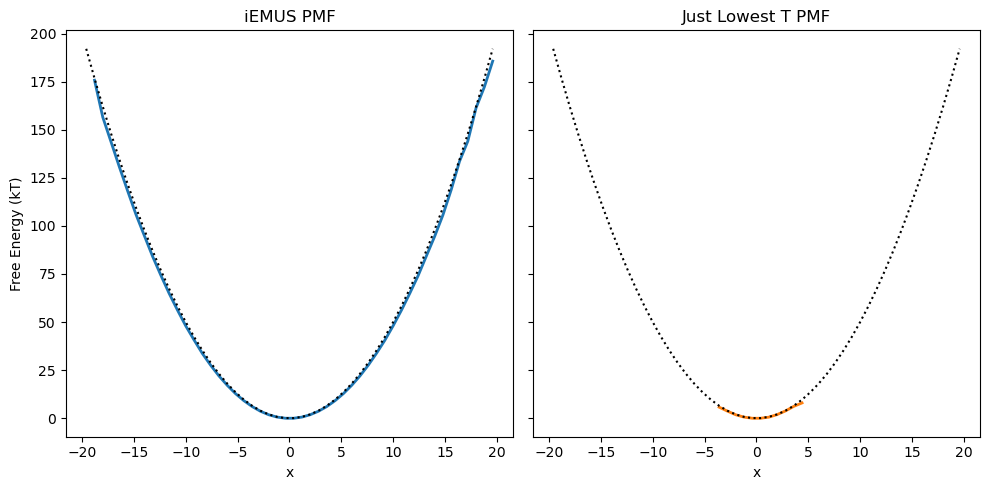

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
axes[0].plot(xax, pmf_many_T, label='EMUS PMF', linewidth=2, color='C0')
axes[1].plot(xax, temp_0_hist, label='Minimum T PMF', linewidth=2, color='C1')

axes[0].set_title("iEMUS PMF")
axes[1].set_title("Just Lowest T PMF")
axes[0].set_ylabel("Free Energy (kT)")


for ax in axes:
    ax.plot(xax, 0.5* xax**2, label='True PMF', color='black', linestyle=':')
    ax.set_xlabel("x")
plt.tight_layout()